# Evaluate Models and Algorithms

## 1. Load python packages and data

In [2]:
import os
import sys
sys.path.append('/Users/damienmellot/desktop/MLE/Projects/fml/call-option-pricing/')
import src.settings.base as stg
from src.infrastructure.optionsfunctions import option_vol_from_surface, call_option_price
from src.infrastructure.datageneration import CallData

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
cd = CallData()
df = cd.data
X = df[stg.FEATURES]
Y = df[stg.TARGET]

## 2. Train Test Split and Evaluation Metrics

In [4]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

We use the prebuild sklearn models to run a k-fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. We will evaluate algorithms using the mean squared error metric and R2 score.

In [5]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

## 3. Compare Models and Algorithms

In [6]:
models = []

#Linear Models and Regression Trees
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Neural Network Predictor
models.append(('MLP', MLPRegressor()))

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [7]:
names = []
kfold_results = []
test_results = []
train_results = []
r2_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    # R2 results
    r2_result = r2_score(Y_test, res.predict(X_test))
    r2_results.append(r2_result)
    
    msg1 = f"{name}:"
    msg2 = f"Cross-Validation Results Mean: {round(cv_results.mean(), 5)}, Cross-Validation Results StDev: {round(cv_results.std(), 5)}"
    msg3 = f"Train result: {round(train_result, 5)}, Test result: {round(test_result, 5)}"
    msg4 = f"R2 score:: {round(r2_result, 5)}"

    print(msg1)
    print(msg2)
    print(msg3)
    print(msg4)
    print('----------------')

LR:
Cross-Validation Results Mean: 0.00036, Cross-Validation Results StDev: 3e-05
Train result: 0.00035, Test result: 0.00036
R2 score:: 0.98103
----------------
LASSO:
Cross-Validation Results Mean: 0.01834, Cross-Validation Results StDev: 0.00111
Train result: 0.01832, Test result: 0.0189
R2 score:: -4e-05
----------------
EN:
Cross-Validation Results Mean: 0.01834, Cross-Validation Results StDev: 0.00111
Train result: 0.01832, Test result: 0.0189
R2 score:: -4e-05
----------------
KNN:
Cross-Validation Results Mean: 2e-05, Cross-Validation Results StDev: 1e-05
Train result: 1e-05, Test result: 2e-05
R2 score:: 0.99896
----------------
CART:
Cross-Validation Results Mean: 1e-05, Cross-Validation Results StDev: 0.0
Train result: 0.0, Test result: 1e-05
R2 score:: 0.99931
----------------
SVR:
Cross-Validation Results Mean: 0.00504, Cross-Validation Results StDev: 0.00016
Train result: 0.00505, Test result: 0.00503
R2 score:: 0.73377
----------------
MLP:
Cross-Validation Results Mean:

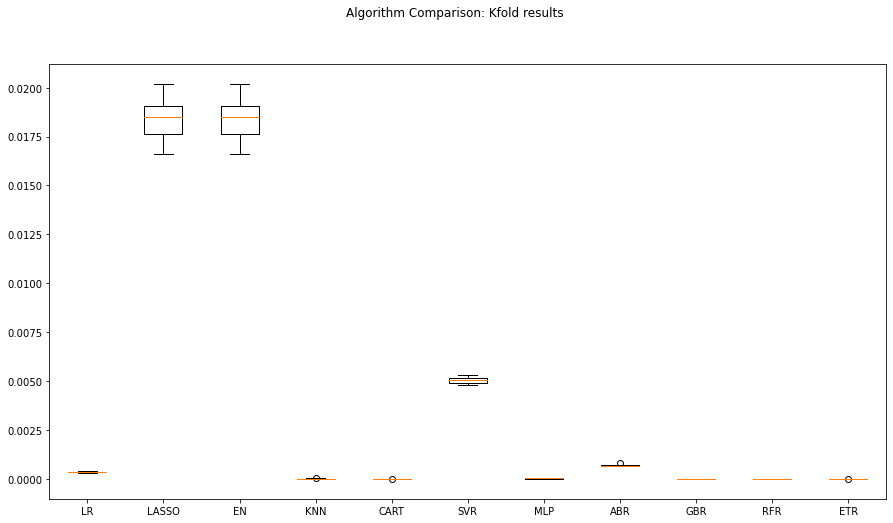

In [8]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

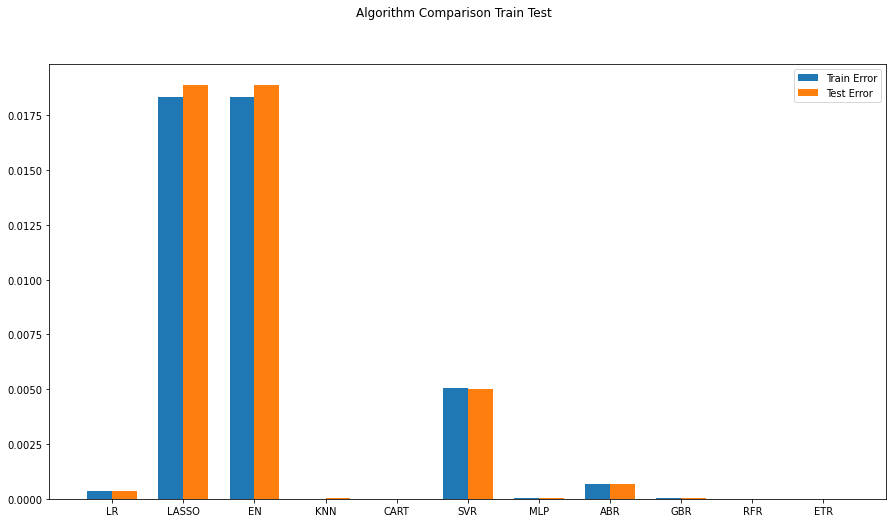

In [9]:
# compare algorithms train test error
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison Train Test')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

We see clearly that the nonlinear models, including classification and regression tree (CART), ensemble models and artifical neural networks (MLP) perform a lot better than the linear algorithms. This is intuitive given the nonlinear relationships we observed in the scatterplot.

ANNs have the natural ability to model any function with fast experimentation and deployment times (definition, training, testing, inference). ANN can effectively bu used in complex derivative pricing situations. Hence, out of all the models with good performance, we choose ANN for further analysis and we perform the grid search for MLP model in the next step.

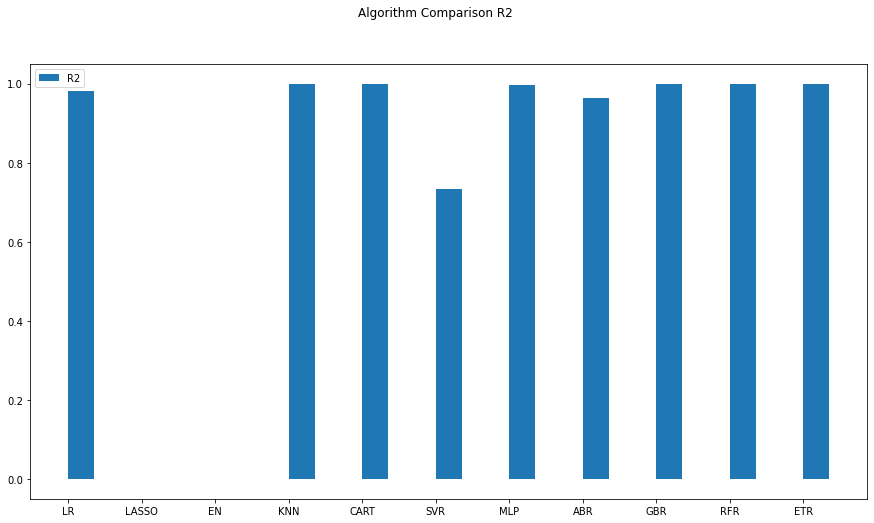

In [10]:
# compare algorithms R2
fig = plt.figure()

ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars

fig.suptitle('Algorithm Comparison R2')
ax = fig.add_subplot(111)
plt.bar(ind + width/2, r2_results, width=width, label='R2')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()